In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from g_media_pipe import extract_data_from_video, save_data
import ast
import glob
import os

In [2]:
directory = os.path.join("model_data", "Squats","Proper")
csv_files = glob.glob(os.path.join(directory, "*.csv"))

In [3]:
csv_files

['model_data\\Squats\\Proper\\properSquat1.csv',
 'model_data\\Squats\\Proper\\ProperSquat10.csv',
 'model_data\\Squats\\Proper\\ProperSquat3.csv',
 'model_data\\Squats\\Proper\\ProperSquat4.csv',
 'model_data\\Squats\\Proper\\ProperSquat5.csv',
 'model_data\\Squats\\Proper\\ProperSquat6.csv',
 'model_data\\Squats\\Proper\\ProperSquat7.csv',
 'model_data\\Squats\\Proper\\ProperSquat8.csv',
 'model_data\\Squats\\Proper\\ProperSquat9.csv',
 'model_data\\Squats\\Proper\\Proper_Squat_1.csv']

In [4]:
calibration_squat = pd.read_csv(csv_files[0])
calibration_squat.head()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,"[0.4244316816329956, 0.22050920128822327, -0.4...","[0.4397614896297455, 0.2081490010023117, -0.40...","[0.44688543677330017, 0.20820307731628418, -0....","[0.45620349049568176, 0.20851349830627441, -0....","[0.4105842709541321, 0.20872071385383606, -0.4...","[0.40054112672805786, 0.20926599204540253, -0....","[0.39335381984710693, 0.2100338488817215, -0.4...","[0.46951591968536377, 0.21445703506469727, -0....","[0.38441023230552673, 0.2165108174085617, -0.2...","[0.44251561164855957, 0.23559340834617615, -0....",...,"[0.5063880681991577, 0.49203425645828247, 0.02...","[0.38032233715057373, 0.49639230966567993, -0....","[0.533027172088623, 0.6365314722061157, -0.002...","[0.3569492697715759, 0.638127863407135, 0.0328...","[0.5481680035591125, 0.736966609954834, 0.4402...","[0.35661524534225464, 0.7428156137466431, 0.47...","[0.5332619547843933, 0.7448287010192871, 0.470...","[0.3717019855976105, 0.7504509687423706, 0.502...","[0.5719988346099854, 0.7900164127349854, 0.257...","[0.3386213183403015, 0.7929822206497192, 0.285..."
1,"[0.4235227406024933, 0.21684443950653076, -0.3...","[0.43903201818466187, 0.20470984280109406, -0....","[0.4468555152416229, 0.20477037131786346, -0.3...","[0.45540836453437805, 0.2048829048871994, -0.3...","[0.40920841693878174, 0.20490750670433044, -0....","[0.3998473286628723, 0.20540988445281982, -0.3...","[0.39174339175224304, 0.20587685704231262, -0....","[0.46900367736816406, 0.21041497588157654, -0....","[0.3836110830307007, 0.21121135354042053, -0.1...","[0.44183802604675293, 0.23266153037548065, -0....",...,"[0.5062860250473022, 0.49120384454727173, 0.01...","[0.38026949763298035, 0.49634894728660583, -0....","[0.5337517857551575, 0.6302443742752075, 0.024...","[0.35608652234077454, 0.6357370018959045, 0.09...","[0.5482008457183838, 0.7303119897842407, 0.440...","[0.35652613639831543, 0.7375196814537048, 0.49...","[0.5332834124565125, 0.7388057112693787, 0.470...","[0.37171733379364014, 0.7449566125869751, 0.52...","[0.5711283683776855, 0.7814869284629822, 0.271...","[0.33687734603881836, 0.7879244089126587, 0.34..."
2,"[0.4227296710014343, 0.2085539996623993, -0.32...","[0.43831613659858704, 0.1960284262895584, -0.2...","[0.44676488637924194, 0.1961459219455719, -0.2...","[0.4543534517288208, 0.1967248022556305, -0.29...","[0.40825068950653076, 0.1967441439628601, -0.2...","[0.39929160475730896, 0.19713343679904938, -0....","[0.39012810587882996, 0.19783255457878113, -0....","[0.4673558175563812, 0.2034216821193695, -0.10...","[0.38233980536460876, 0.20453612506389618, -0....","[0.4414278566837311, 0.22501909732818604, -0.2...",...,"[0.5055862665176392, 0.489584743976593, 0.0137...","[0.38004928827285767, 0.4954547882080078, -0.0...","[0.5339826345443726, 0.6249909400939941, 0.007...","[0.35355886816978455, 0.6311861276626587, 0.03...","[0.5480718016624451, 0.7260529398918152, 0.353...","[0.3564785122871399, 0.7328090071678162, 0.314...","[0.5322403311729431, 0.7342929244041443, 0.377...","[0.37170639634132385, 0.7412026524543762, 0.33...","[0.570963978767395, 0.7752067446708679, 0.2085...","[0.33661699295043945, 0.7841972708702087, 0.16..."
3,"[0.42150789499282837, 0.20228520035743713, -0....","[0.4364469349384308, 0.18947520852088928, -0.2...","[0.4458343982696533, 0.1896168440580368, -0.26...","[0.452472060918808, 0.19035115838050842, -0.26...","[0.4065835177898407, 0.18994715809822083, -0.2...","[0.39792320132255554, 0.1900908648967743, -0.2...","[0.3879556357860565, 0.19088976085186005, -0.2...","[0.4640847146511078, 0.19738951325416565, -0.0...","[0.380149245262146, 0.19864614307880402, -0.10...","[0.4403133690357208, 0.2188064306974411, -0.21...",...,"[0.5046833753585815, 0.4868897497653961, 0.010...","[0.378551185131073, 0.49287357926368713, -0.0

In [ ]:
def euclidean(joint1,joint2):
        joint1 = eval(joint1)
        joint2 = eval(joint2)
        xi,yi,zi = joint1
        xj,yj,zj = joint2
        return (np.square(xi-xj)+np.square(yi-yj)+np.square(zi-zj))**0.5

def calculate_joint_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

import math


# def compute_row(row):
#         n = len(row)
#         output = np.zeros((33,33))
#         for i in range(n):
#             for j in range(n):
#                    output[i][j] = euclidean(row.iloc[i],row.iloc[j])
#         return output[np.triu_indices(33,k=1)]
        
# matrix = df.apply(lambda row: compute_row(row),axis=1)
# print(matrix.shape)
#matrix[np.triu_indices(33, k=1)].shape

In [44]:
class VideoProcessingPipeline: 
    """
    Class for identifying the number of squats done in a .mp4 video
    """
    def __init__(self,video_file_path:str,threshold:float = 0.25) -> None:
        self.threshold = threshold
        raw_data = extract_data_from_video(video_path=video_file_path)
        df = pd.DataFrame(raw_data).drop(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX','LEFT_THUMB', 'RIGHT_THUMB','LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'],axis=1)
        processed_df = self.process_df(df)
        for col in processed_df.columns:
            processed_df[col] = self.smooth_gaussian(self.min_max_scaler(processed_df[col]))
        self.data = processed_df
        
    def process_df(self,data:pd.DataFrame) -> pd.DataFrame:
        if isinstance(data.iloc[0][0],str):
            data = data.map(ast.literal_eval)

        x_coors = data.map(lambda coords: coords[0])  # Get the X coordinates
        y_coors = data.map(lambda coords: coords[1])  # Get the Y coordinates
        z_coors = data.map(lambda coords: coords[2])  # Get the Z coordinates

        # If you want to combine these into a single DataFrame with columns like NOSE_x, NOSE_y, NOSE_z, etc.
        x_coors.columns = [f'{col}_x' for col in x_coors.columns]
        y_coors.columns = [f'{col}_y' for col in y_coors.columns]
        z_coors.columns = [f'{col}_z' for col in z_coors.columns]
        # Combine the x, y, z data into a single DataFrame
        return pd.concat([x_coors, y_coors, z_coors], axis=1)
    
    def min_max_scaler(self,col:pd.Series)->pd.Series:
        min_value = np.min(col)
        max_value = np.max(col)
        return col.map(lambda x: (x-min_value)/(max_value-min_value))
    
    def smooth_gaussian(self,data:pd.Series, sigma=2)->pd.Series:
        """
        Smoothen the curves using a Gaussian filter.

        Parameters:
        - data: NumPy array, the input signal to smooth.
        - sigma: Standard deviation of the Gaussian kernel.

        Returns:
        - smoothed_data: NumPy array of the smoothed data.
        """
        kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
        x = np.arange(-kernel_radius, kernel_radius + 1)
        gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
        gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
        
        # Padding to avoid edge effects
        padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
        
        # Convolution with Gaussian kernel
        smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
        
        return smoothed_data
    
    def count_reps(self):
        left_knee_count = right_knee_count = 0
        right_knee_col = self.data['RIGHT_KNEE_z']
        left_knee_col = self.data['LEFT_KNEE_z']
        for i in range(len(right_knee_col)-1):
            if right_knee_col[i] > self.threshold and right_knee_col[i+1] <= self.threshold:
                right_knee_count += 1
            if left_knee_col[i] > self.threshold and left_knee_col[i+1] <= self.threshold:
                left_knee_count += 1
        return (left_knee_count,right_knee_count)

In [37]:
# read a new mp4 file and count the number of reps
#pipeline = VideoProcessingPipeline(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4")
#save_data(videoData=video_data,output_path=r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\datasets\Test\Squats_8_reps.csv")
pipeline = extract_data_from_video(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4")
pipeline = pd.DataFrame.from_dict(pipeline)
pipeline.head()

Extracting data from video file: D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4


d:\Anaconda\envs\capstone\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,"[0.5477468371391296, 0.1862887442111969, -0.19...","[0.5537805557250977, 0.1730068325996399, -0.20...","[0.556646466255188, 0.17262625694274902, -0.20...","[0.559933066368103, 0.17199483513832092, -0.20...","[0.5501401424407959, 0.17286059260368347, -0.1...","[0.5499127507209778, 0.17256546020507812, -0.1...","[0.5496770143508911, 0.17215272784233093, -0.1...","[0.5753992795944214, 0.17973151803016663, -0.2...","[0.5607523322105408, 0.17849597334861755, -0.0...","[0.5523327589035034, 0.20453768968582153, -0.1...",...,"[0.5797024965286255, 0.5123887658119202, -0.07...","[0.5520291924476624, 0.5104167461395264, 0.079...","[0.588586151599884, 0.6958849430084229, -0.077...","[0.5527110695838928, 0.6799314618110657, 0.176...","[0.6042733192443848, 0.8868828415870667, -0.03...","[0.5526856184005737, 0.8301747441291809, 0.305...","[0.6124616861343384, 0.910771369934082, -0.036...","[0.5587644577026367, 0.8542110919952393, 0.312...","[0.5672720074653625, 0.925087034702301, -0.147...","[0.5119575262069702, 0.8571917414665222, 0.249..."
1,"[0.5477819442749023, 0.18639196455478668, -0.2...","[0.554099440574646, 0.17304591834545135, -0.21...","[0.5570525527000427, 0.172659233212471, -0.213...","[0.5603120923042297, 0.17200981080532074, -0.2...","[0.5501700639724731, 0.17290280759334564, -0.1...","[0.5499053597450256, 0.17263373732566833, -0.1...","[0.5495833158493042, 0.17224790155887604, -0.1...","[0.57541424036026, 0.17954720556735992, -0.204...","[0.5604302287101746, 0.1785285919904709, -0.08...","[0.5532244443893433, 0.20456063747406006, -0.1...",...,"[0.5795183181762695, 0.5124853253364563, -0.08...","[0.5502452254295349, 0.5104004740715027, 0.080...","[0.5884933471679688, 0.6956729292869568, -0.09...","[0.55270916223526, 0.6797372698783875, 0.19563...","[0.604367196559906, 0.8881517052650452, -0.068...","[0.5526731014251709, 0.8301785588264465, 0.356...","[0.6124933958053589, 0.9126052856445312, -0.07...","[0.5593600273132324, 0.8539450764656067, 0.366...","[0.5672467947006226, 0.9251440167427063, -0.19...","[0.5136159062385559, 0.8574672937393188, 0.301..."
2,"[0.5477809906005859, 0.18648649752140045, -0.2...","[0.5541593432426453, 0.1731390804052353, -0.21...","[0.5570969581604004, 0.17276670038700104, -0.2...","[0.5603408813476562, 0.172113835811615, -0.219...","[0.5501707792282104, 0.1729656457901001, -0.19...","[0.5498813390731812, 0.17272192239761353, -0.1...","[0.5495029091835022, 0.17235827445983887, -0.1...","[0.5753521919250488, 0.17945416271686554, -0.2...","[0.5602519512176514, 0.17855964601039886, -0.0...","[0.5535476207733154, 0.204573392868042, -0.201...",...,"[0.5793458223342896, 0.5125335454940796, -0.08...","[0.5492851138114929, 0.5103565454483032, 0.081...","[0.5882595181465149, 0.6954410076141357, -0.10...","[0.5526494383811951, 0.6796890497207642, 0.200...","[0.6044007539749146, 0.8890522718429565, -0.06...","[0.5526500940322876, 0.8301746845245361, 0.364...","[0.6125483512878418, 0.9137364625930786, -0.07...","[0.5597427487373352, 0.853651762008667, 0.3743...","[0.5671133995056152, 0.9254457354545593, -0.19...","[0.5143700242042542, 0.8581336736679077, 0.308..."
3,"[0.5477818250656128, 0.18675613403320312, -0.2...","[0.5542267560958862, 0.17332440614700317, -0.2...","[0.557159960269928, 0.17296193540096283, -0.23...","[0.5603882670402527, 0.17230305075645447, -0.2...","[0.5501710176467896, 0.17313314974308014, -0.2...","[0.5498518943786621, 0.1729344129562378, -0.20...","[0.5494158864021301, 0.17262014746665955, -0.2...","[0.5753194093704224, 0.1794222891330719, -0.21...","[0.5601145625114441, 0.1786852777004242, -0.08...","[0.5538148283958435, 0.20463496446609497, -0.2...",...,"[0.5790977478027344, 0.5128382444381714, -0.08...","[0.548896849155426, 0.5103697180747986, 0.082

In [47]:
pipeline.columns
df = pipeline.copy()

In [ ]:
def smooth_gaussian(data:pd.Series, sigma=2)->pd.Series:
    """
    Smoothen the curves using a Gaussian filter.
    Parameters:
    - data: NumPy array, the input signal to smooth.
    - sigma: Standard deviation of the Gaussian kernel.
    Returns:
    - smoothed_data: NumPy array of the smoothed data.
    """
    kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
    x = np.arange(-kernel_radius, kernel_radius + 1)
    gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
    gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
    
    # Padding to avoid edge effects
    padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
    
    # Convolution with Gaussian kernel
    smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
    
    return pd.Series(smoothed_data,index=data.index)

def calculate_angle(joint_a, joint_b, joint_c):
    """
    Calculate the angle between three joints in 3D space.
    
    Args:
    joint_a (tuple): The (x, y, z) coordinates of the first joint.
    joint_b (tuple): The (x, y, z) coordinates of the second joint (vertex joint).
    joint_c (tuple): The (x, y, z) coordinates of the third joint.
    
    Returns:
    float: The angle in degrees between the three joints.
    """
    # Calculate vectors: Joint A to B and Joint B to C
    vector_ab = (
        joint_b[0] - joint_a[0],
        joint_b[1] - joint_a[1],
        joint_b[2] - joint_a[2]
    )
    vector_bc = (
        joint_c[0] - joint_b[0],
        joint_c[1] - joint_b[1],
        joint_c[2] - joint_b[2]
    )
    
    # Calculate the dot product of the two vectors
    dot_product = (
        vector_ab[0] * vector_bc[0] +
        vector_ab[1] * vector_bc[1] +
        vector_ab[2] * vector_bc[2]
    )
    
    # Calculate the magnitudes of the vectors
    magnitude_ab = math.sqrt(
        vector_ab[0] ** 2 + vector_ab[1] ** 2 + vector_ab[2] ** 2
    )
    magnitude_bc = math.sqrt(
        vector_bc[0] ** 2 + vector_bc[1] ** 2 + vector_bc[2] ** 2
    )
    
    # Avoid division by zero by ensuring valid magnitude values
    if magnitude_ab == 0 or magnitude_bc == 0:
        raise ValueError("One of the vectors has zero length, can't calculate angle.")
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_ab * magnitude_bc)
    
    # Ensure the value of cos_theta is within [-1, 1] to avoid math domain errors
    cos_theta = max(min(cos_theta, 1.0), -1.0)
    
    # Calculate the angle in radians, then convert to degrees
    angle_rad = math.acos(cos_theta)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

def plot_joint_angles(df, joints, angle_name="Angle"):
    """
    Calculate and plot joint angles over time.

    Args:
    df (pd.DataFrame): DataFrame containing joint positions for each timeframe.
    joints (list): List of three joints as tuples of (x, y, z) columns.
    angle_name (str): Name for the angle being calculated.
    """
    joint_a, joint_b, joint_c = joints
    
    # Initialize an empty list to store the angles
    angles = []
    
    # Iterate over each row (timeframe) in the DataFrame
    for _, row in df.iterrows():
        # Extract joint coordinates
        a_coords = row[joint_a]
        b_coords = row[joint_b]
        c_coords = row[joint_c]
        
        # Calculate angle and append to list
        angle = calculate_angle(a_coords, b_coords, c_coords)
        angles.append(angle)
    
    # Plot the angles over time
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, angles, label=f'{angle_name}')
    plt.xlabel("Timeframe")
    plt.ylabel("Angle (degrees)")
    plt.title(f'{angle_name} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

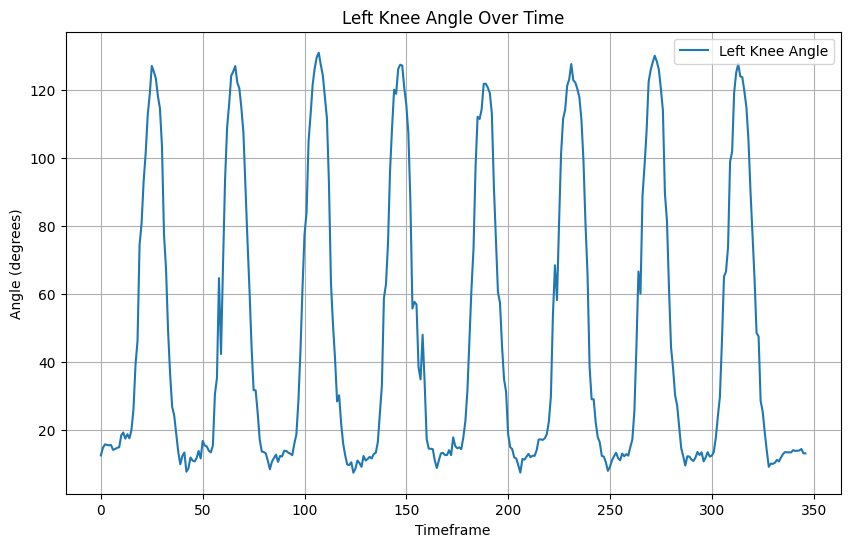

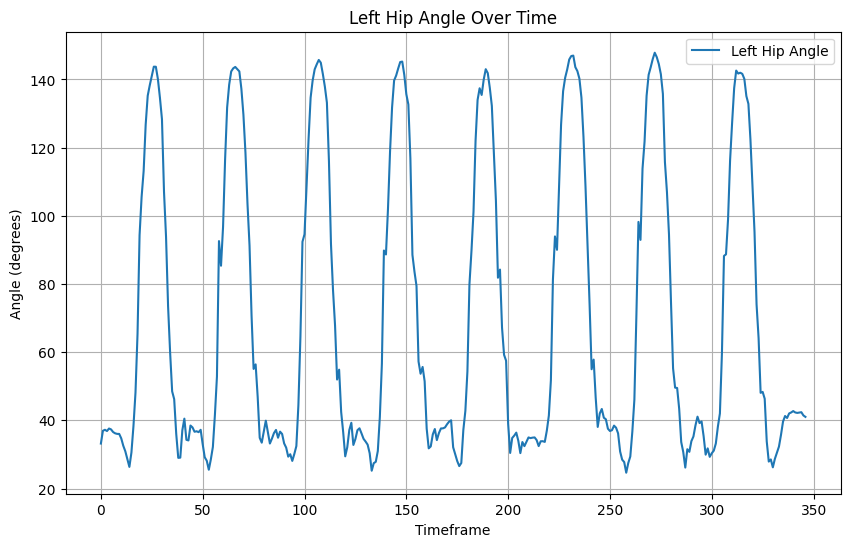

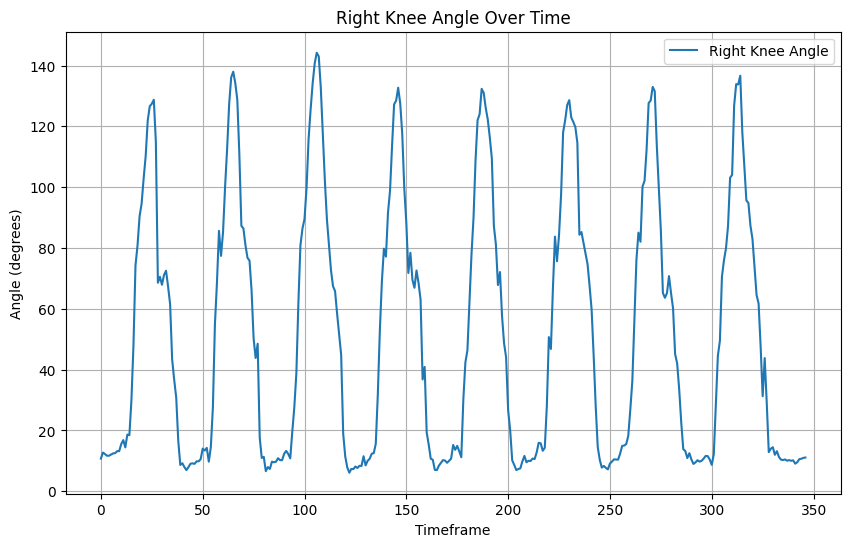

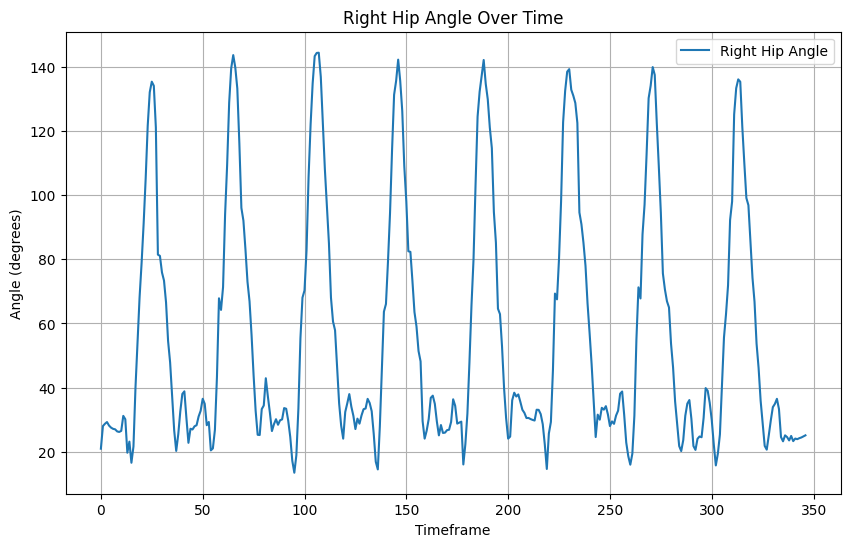

In [58]:
# Define joint groups for left side (similar logic applies to right side)
left_knee_angle_joints = ("LEFT_HIP", "LEFT_KNEE", "LEFT_ANKLE")
left_hip_angle_joints = ("LEFT_SHOULDER", "LEFT_HIP", "LEFT_KNEE")
#left_ankle_angle_joints = ("LEFT_KNEE", "LEFT_ANKLE", "LEFT_FOOT_INDEX")

right_knee_angle_joints = ("RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE")
right_hip_angle_joints = ("RIGHT_SHOULDER", "RIGHT_HIP", "RIGHT_KNEE")
#right_ankle_angle_joints = ("RIGHT_KNEE", "RIGHT_ANKLE", "RIGHT_FOOT_INDEX")

# Example of plotting angles for different joints for a squat motion
plot_joint_angles(df, left_knee_angle_joints, "Left Knee Angle")
plot_joint_angles(df, left_hip_angle_joints, "Left Hip Angle")
#plot_joint_angles(df, left_ankle_angle_joints, "Left Ankle Angle")

plot_joint_angles(df, right_knee_angle_joints, "Right Knee Angle")
plot_joint_angles(df, right_hip_angle_joints, "Right Hip Angle")
#plot_joint_angles(df, right_ankle_angle_joints, "Right Ankle Angle")


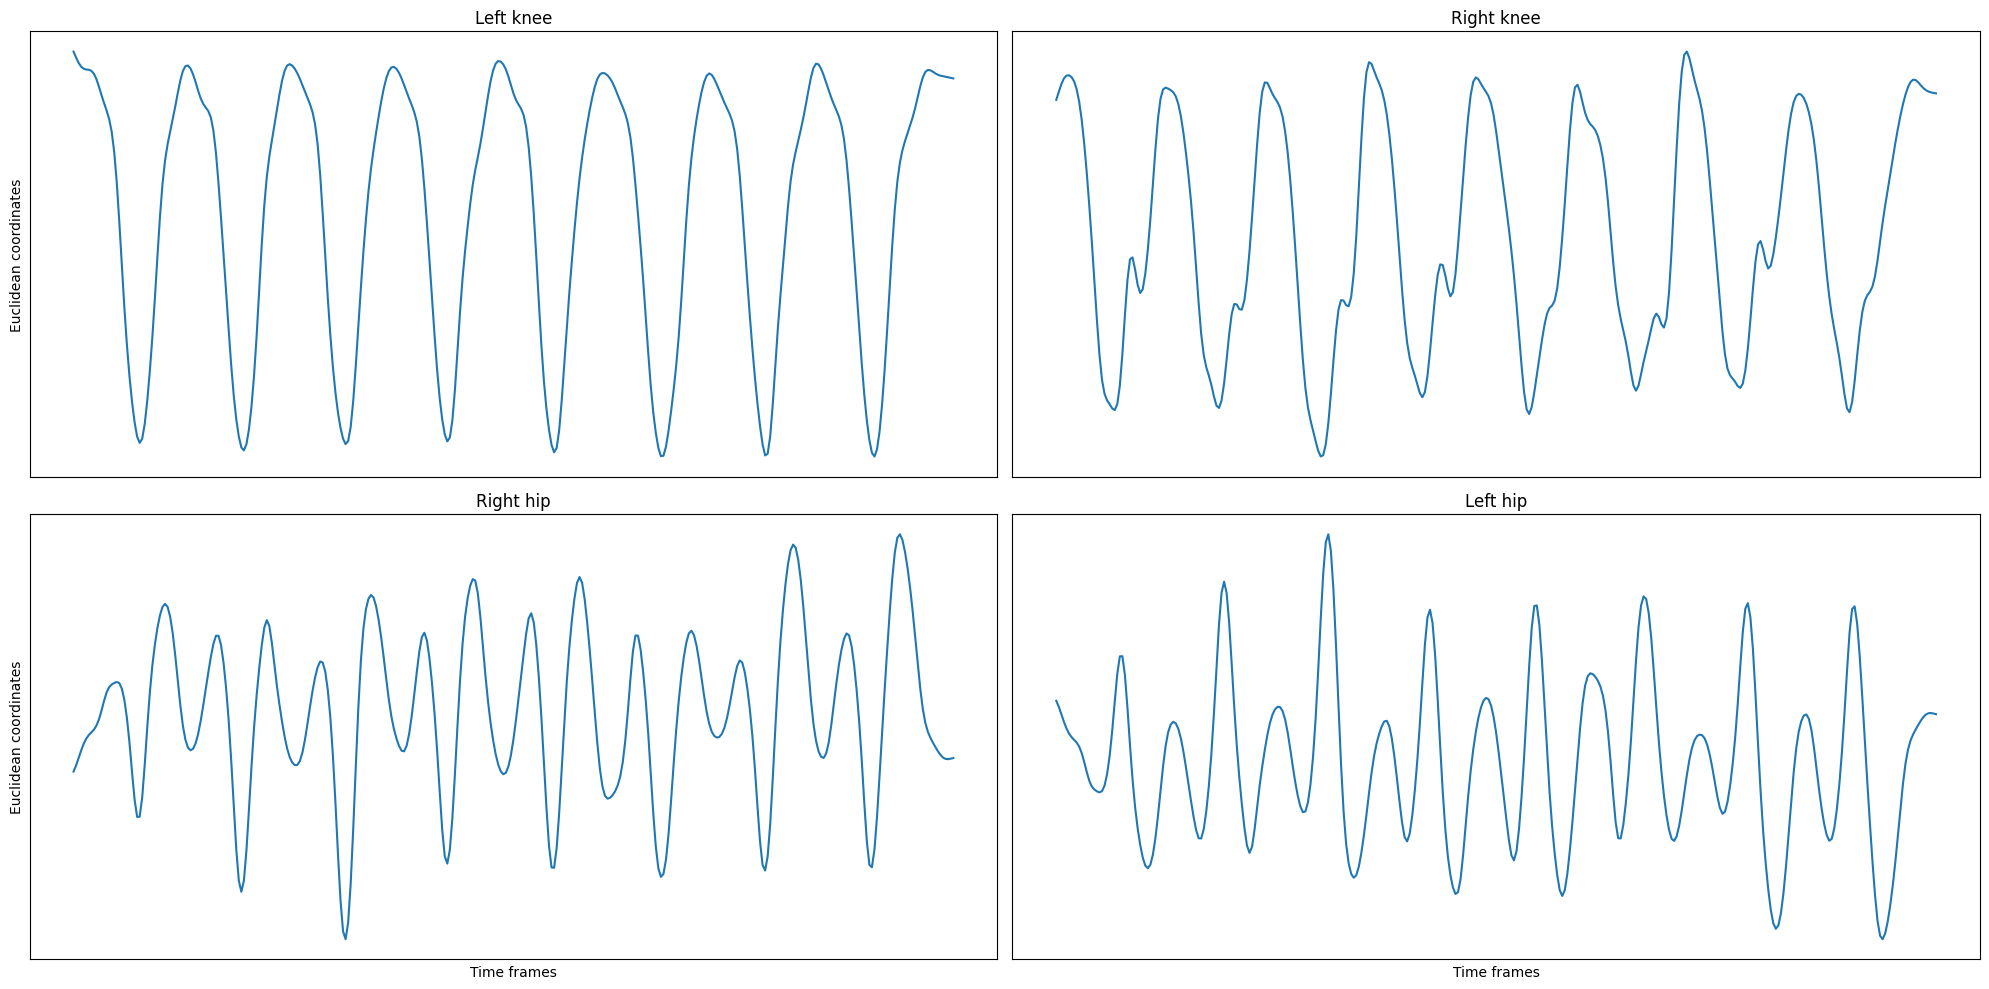

In [11]:
plt.figure(figsize=(20, 10))

# First row, first plot: LEFT_KNEE_z
plt.subplot(221)
plt.plot(pipeline.data['LEFT_KNEE_z'])
plt.title('Left knee')
plt.xticks([]), plt.yticks([])
plt.ylabel("Euclidean coordinates")

# First row, second plot: RIGHT_KNEE_z
plt.subplot(222)
plt.plot(pipeline.data['RIGHT_KNEE_z'])
plt.title('Right knee')
plt.xticks([]), plt.yticks([])

# Second row, first plot: RIGHT_HIP_z
plt.subplot(223)
plt.plot(pipeline.data['RIGHT_HIP_z'])
plt.title('Right hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")
plt.ylabel("Euclidean coordinates")

# Second row, second plot: LEFT_HIP_z
plt.subplot(224)
plt.plot(pipeline.data['LEFT_HIP_z'])
plt.title('Left hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")

plt.tight_layout()
plt.show()


In [55]:
df_test = pd.read_csv(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\live_stream_test2.csv")
df_test.head()

,LEFT_HIP_x,RIGHT_HIP_x,LEFT_KNEE_x,RIGHT_KNEE_x,LEFT_HIP_y,RIGHT_HIP_y,LEFT_KNEE_y,RIGHT_KNEE_y,LEFT_HIP_z,RIGHT_HIP_z,LEFT_KNEE_z,RIGHT_KNEE_z
0,0.367449,0.367978,0.369028,0.370651,0.372835,0.375256,0.377831,0.380374,0.382670,0.384382,0.385463,0.386127
1,0.363202,0.363729,0.364776,0.366415,0.368610,0.371048,0.373642,0.376202,0.378524,0.380243,0.381330,0.381995
2,0.350156,0.350663,0.351681,0.353332,0.355520,0.357952,0.360543,0.363103,0.365455,0.367160,0.368236,0.368890
3,0.342797,0.343299,0.344330,0.346022,0.348261,0.350753,0.353407,0.356035,0.358459,0.360202,0.361294,0.361962
4,0.337202,0.337702,0.338698,0.340420,0.342657,0.345151,0.347810,0.350437,0.352904,0.354625,0.355718,0.356381


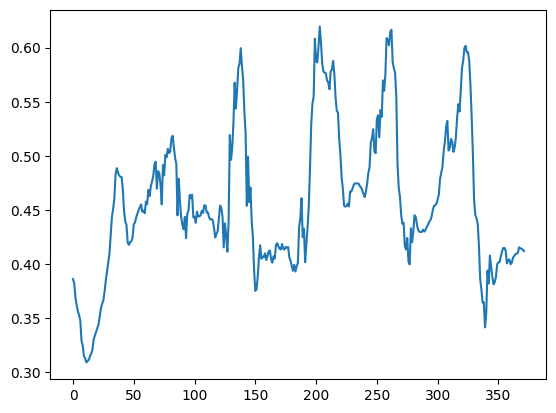

In [57]:
plt.plot(df_test["RIGHT_KNEE_z"])

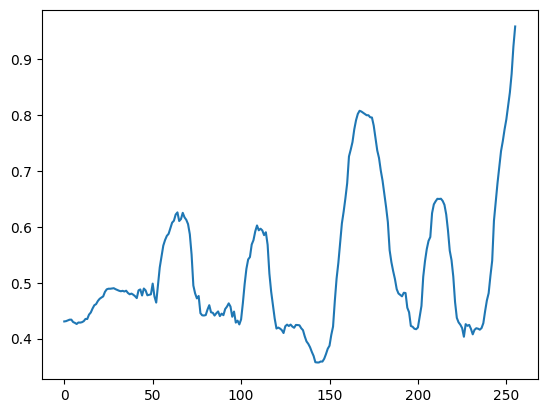

In [29]:
plt.plot(df_test["RIGHT_KNEE_z"])